# US Senate Exploratory Data Analysis

As already mentioned, the scope of this analysis is limited in the Senate body of US congress. The House of Representatives has 435 members so I deemed that this would complicate things and just "dilute" similar findings. In addition, as the Senate has less members, individuals are more crucial for the successful outcome of a bill and compromises are more difficult to broker, especially in closely divided Senates in the last couple of years.

This notebook attempts to offer a preliminary analysis and vizualization of certain traits and statistics without curving any network analysis yet. This will be covered in the second notebook.

Data was drawn from the US congress API. More information on that can be found in https://api.congress.gov/#/.

In [1]:
import config
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from urllib.request import urlopen
import ast
import datetime
import os
import altair as alt
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', None)
pd.options.mode.copy_on_write = True

In [2]:
API_KEY = config.api_key
current_directory = os.getcwd()
main_dir = os.path.dirname(current_directory)
data = os.path.join(os.path.dirname(current_directory), "data")
images = os.path.join(os.path.dirname(current_directory), "images")
htmls = os.path.join(os.path.dirname(current_directory), "htmls")

In [3]:
#A function to return a dataframe with all recorded congress members
def members_to_df(url):
    response = urlopen(url)
    response_content = response.read().decode('utf-8')
    responseJson = json.loads(response_content)
    df = pd.DataFrame.from_records(responseJson['members'])

    while("next" in responseJson['pagination'].keys()):
        next_url = responseJson['pagination']['next'] + f"&api_key={API_KEY}"
        response = urlopen(next_url)
        response_content = response.read().decode('utf-8')
        responseJson = json.loads(response_content)
        df_i = pd.DataFrame.from_records(responseJson['members'])
        df = pd.concat([df,df_i])
    
    return df

In [4]:
members = members_to_df(f'https://api.congress.gov/v3/member?limit=250&api_key={API_KEY}')
print(members.columns)
members = members.filter(items=['bioguideId','name','terms']).dropna()
members.to_csv(data + "//members.csv",index=False)

Index(['bioguideId', 'depiction', 'name', 'partyName', 'state', 'terms',
       'updateDate', 'url', 'district'],
      dtype='object')


In [5]:
df = pd.read_csv(data + "//members.csv",index_col='bioguideId')
df.head(3)

,name,terms
bioguideId,,
M001190,"Mullin, Markwayne","{'item': [{'chamber': 'House of Representatives', 'endYear': 2023, 'startYear': 2013}, {'chamber': 'Senate', 'startYear': 2023}]}"
W000253,"Weicker, Lowell P., Jr.","{'item': [{'chamber': 'House of Representatives', 'endYear': 1971, 'startYear': 1969}, {'chamber': 'Senate', 'endYear': 1989, 'startYear': 1973}]}"
E000071,"Ellzey, Jake","{'item': [{'chamber': 'House of Representatives', 'startYear': 2021}]}"


In [6]:
#A function that returns true for all members of a given chamber ('Senate' or 'House of Representatives')...
#...at a given congressional period (2 year periods)
def congress (x,congress_period, chamber):

    terms = ast.literal_eval(x)['item']
    
    for term in terms:

        if term['chamber'] != chamber:
            continue
        
        if 'endYear' not in term.keys() and term['startYear'] < congress_period[1]:
            return True
        
        if 'endYear' in term.keys():
            if term['endYear'] >= congress_period[1] and term['startYear'] <= congress_period[1]:
                return True
            elif term['endYear'] <= congress_period[1] and term['endYear'] > congress_period[0]:
                return True
            elif term['startYear'] <= congress_period[1] and term['startYear'] > congress_period[0]:
                return True
            else:
                continue
    return False

The Senate body consists of a fixed number of 100 members. Usually, there are more than 100 members, due to special elections, resignations, deaths etc. We output the total number of lawmakers in the last 4 Senates below:

In [7]:
c = 0
for i in range(0,8,2):
    print(f"Period {2021-i} - {2023-i}")
    senate = df.loc[df['terms'].apply(congress,congress_period=(2021-i,2023-i),chamber='Senate')]
    print(senate.shape,"\n")

Period 2021 - 2023
(100, 2) 

Period 2019 - 2021
(101, 2) 

Period 2017 - 2019
(105, 2) 

Period 2015 - 2017
(102, 2) 



## Age makeup of Senate throughout the years

In [8]:
def birth_year(x):
    response = urlopen(f"https://api.congress.gov/v3/member/{x}/?format=json&api_key={API_KEY}")
    response_content = response.read().decode('utf-8')
    responseJson = json.loads(response_content)
    member_info = responseJson.get('member', {})
    birth_year = member_info.get('birthYear')
    return int(birth_year)


#1000 requests per hour
sampled_df = df.sample(n=900)

sampled_df['birthYear'] = sampled_df.apply(lambda row: birth_year(row.name), axis=1)

<Figure size 720x720 with 0 Axes>

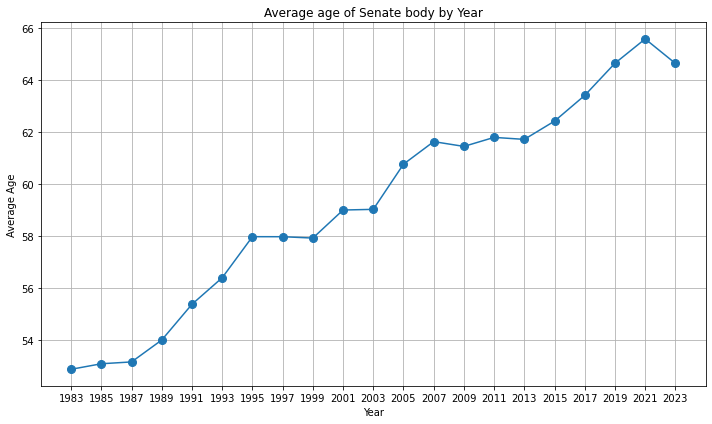

In [9]:
avg_age = []

for i in range(0, 42, 2):
    
    temp_df = sampled_df.loc[df['terms'].apply(congress,congress_period=(1983+i,1985+i),chamber='Senate')]
    
    avg_age.append((1983+i-temp_df['birthYear'].mean(),1983+i))
    
fig = plt.figure(figsize=(10, 10))

years = [entry[1] for entry in avg_age]
values = [entry[0] for entry in avg_age]

plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', markersize=8)

plt.xticks(range(min(years), max(years) + 1, 2))

plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Average age of Senate body by Year')

plt.grid(True)
plt.tight_layout()
plt.savefig(images + "//average_age.png", transparent=True, facecolor='w')

Although, felt by most people, this graph showcases how in 40 years the average age of a Senate member has risen by almost 12 years! In the United States it is generally considered that a senior citizen is anyone of retirement age, or a person that has reached age 62.

In [10]:
#A function to calculate how many years one served at both chambers, applied to the 'terms' column of the dataframe
def years_in_office (x):
    terms = ast.literal_eval(x['terms'])['item']
    
    years_house = 0
    years_senate = 0
    
    for term in terms:
        if 'endYear' not in term.keys():
            end = datetime.date.today().year
        else:
            end = term['endYear']
            
        if term['chamber'] ==  'House of Representatives':
            years_house += end - term['startYear'] + 1
        else:
            years_senate += end - term['startYear'] + 1    
            
    return years_house, years_senate

## Current Senate (2023)

In [11]:
current_senate = df.loc[df['terms'].apply(congress,congress_period=(2023,2025),chamber='Senate')]
current_senate

,name,terms
bioguideId,,
M001190,"Mullin, Markwayne","{'item': [{'chamber': 'House of Representatives', 'endYear': 2023, 'startYear': 2013}, {'chamber': 'Senate', 'startYear': 2023}]}"
W000800,"Welch, Peter","{'item': [{'chamber': 'House of Representatives', 'endYear': 2023, 'startYear': 2007}, {'chamber': 'Senate', 'startYear': 2023}]}"
F000479,"Fetterman, John","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}"
S001227,"Schmitt, Eric","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}"
V000137,"Vance, J. D.","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}"
...,...,...
B001277,"Blumenthal, Richard","{'item': [{'chamber': 'Senate', 'startYear': 2011}]}"
B001261,"Barrasso, John","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}"
B001267,"Bennet, Michael F.","{'item': [{'chamber': 'Senate', 'startYear': 2009}]}"


In [12]:
years_df = current_senate.apply(lambda row: years_in_office(row), axis=1, result_type='expand')
current_senate[['years_house', 'years_senate']] = years_df
current_senate

,name,terms,years_house,years_senate
bioguideId,,,,
M001190,"Mullin, Markwayne","{'item': [{'chamber': 'House of Representatives', 'endYear': 2023, 'startYear': 2013}, {'chamber': 'Senate', 'startYear': 2023}]}",11,1
W000800,"Welch, Peter","{'item': [{'chamber': 'House of Representatives', 'endYear': 2023, 'startYear': 2007}, {'chamber': 'Senate', 'startYear': 2023}]}",17,1
F000479,"Fetterman, John","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}",0,1
S001227,"Schmitt, Eric","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}",0,1
V000137,"Vance, J. D.","{'item': [{'chamber': 'Senate', 'startYear': 2023}]}",0,1
...,...,...,...,...
B001277,"Blumenthal, Richard","{'item': [{'chamber': 'Senate', 'startYear': 2011}]}",0,13
B001261,"Barrasso, John","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}",0,17
B001267,"Bennet, Michael F.","{'item': [{'chamber': 'Senate', 'startYear': 2009}]}",0,15


In [13]:
current_senate.to_csv(data + "//current_senate.csv",index='bioguideId')

In [14]:
current_senate = pd.read_csv(data + "//current_senate.csv")

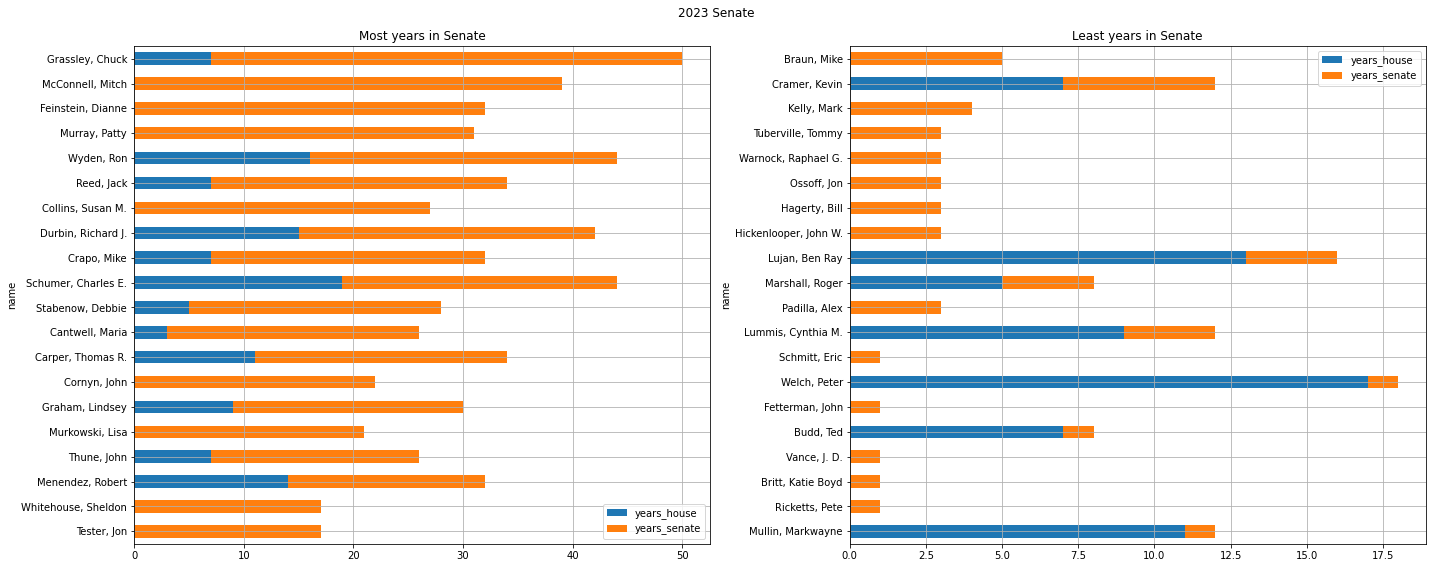

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
plot_senate = current_senate.copy(deep=True).set_index('name')
plot_senate = plot_senate.sort_values("years_senate")
fig.suptitle("2023 Senate")
ax1.set_title("Most years in Senate")
ax2.set_title("Least years in Senate")
plot_senate[['years_house','years_senate']][:20].plot(kind='barh', stacked=True, grid=True, ax=ax2)
plot_senate[['years_house','years_senate']][80:].plot(kind='barh', stacked=True, grid=True, ax=ax1)
fig.tight_layout()
plt.savefig(images + "//tenure.png",transparent=True,facecolor='w')

It is known that most Senators usually make their name in the House. This can be noted from the left figure with the most senior members, where **12 out of 20** Senators also served in the House. Nearly half of them did so for more than 10 years. The current Senate, on the other hand, can be noted for accepting some really fresh faces among its ranks. Only **7 out of 20** Senators served in the House before entering the Senate.

Note that it is very unusuall for a Senator to subsequently serve in the House of Representatives. According to a lazy prompt in ChatGTP (taken with a grain of salt🙃), only 19 individuals did so! For this reason, we made a bulk calculation in the 'years_in_office' function.

Fun fact: According to senate.gov 17 senators have also served as president of the United States. Three senators, Warren G. Harding, John F. Kennedy, and Barack Obama, moved directly from the U.S. Senate to the White House.

## Super-Senate

Here, I introduce the term "super-senate", which just constitutes a "merged" body of certain consecutive congressional periods.

This decision, was made for the following reasons:

- There aren't that many bills in only one congressional period that actually pass the Senate.

- Thus, we could not trace many good relationships.

- Congressional "clusters" could take some years to develop, as every human relationship. 

- The number of successful bills is also dependent on the Senate majority. The Senate majority leader can decide on which bills will go to a vote, so judging only by a congressional period would have a biase towards the one or the other party.

### Duration of study: 2011-2021

3 intervals with **Democratic Senate majority** and Democratic President (2011-2013, 2013-2015, 2021-2023)

2 intervals with **Republican Senate majority** and Republican President (2017-2019, 2019-2021)

1 interval with **Republican Senate majority** and Democratic President (2015-2017)

**This gives us an equally weighted "super-senate", upon which we will continue our analysis.**

In [16]:
#Create 2011-2021 "Super-Senate"
#2011-2013 ------> 112th United States Congress
#2019-2021 ------> 116th United States Congress 

In [17]:
super_senate = df.loc[df['terms'].apply(congress,congress_period=(2011,2021),chamber='Senate')]
super_senate

,name,terms
bioguideId,,
C001098,"Cruz, Ted","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}"
W000817,"Warren, Elizabeth","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}"
W000802,"Whitehouse, Sheldon","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}"
Y000064,"Young, Todd","{'item': [{'chamber': 'House of Representatives', 'endYear': 2017, 'startYear': 2011}, {'chamber': 'Senate', 'startYear': 2017}]}"
W000779,"Wyden, Ron","{'item': [{'chamber': 'House of Representatives', 'endYear': 1996, 'startYear': 1981}, {'chamber': 'Senate', 'startYear': 1996}]}"
...,...,...
B000243,"Baucus, Max","{'item': [{'chamber': 'House of Representatives', 'endYear': 1979, 'startYear': 1975}, {'chamber': 'Senate', 'endYear': 2014, 'startYear': 1979}]}"
A000069,"Akaka, Daniel K.","{'item': [{'chamber': 'House of Representatives', 'endYear': 1991, 'startYear': 1977}, {'chamber': 'Senate', 'endYear': 2013, 'startYear': 1990}]}"
K000352,"Kyl, Jon","{'item': [{'chamber': 'House of Representatives', 'endYear': 1995, 'startYear': 1987}, {'chamber': 'Senate', 'endYear': 2013, 'startYear': 1995}, {'chamber': 'Senate', 'endYear': 2019, 'startYear': 2018}]}"


### Let's add more data to the super-Senate dataset

- State
- Party
- Birth year


- Sponsored Legislation count
- Sponsored Legislation URL


- Cosponsored Legislation count
- Cosponsored Legislation URL

In [18]:
def enrich_senate(x):
    response = urlopen(f"https://api.congress.gov/v3/member/{x}/?format=json&api_key={API_KEY}")
    response_content = response.read().decode('utf-8')
    responseJson = json.loads(response_content)

    member_info = responseJson.get('member', {})
    state = member_info.get('state')
    party = responseJson['member']['partyHistory'][-1]['partyName']
    birth_year = member_info.get('birthYear')
    sponsored_count = member_info.get('sponsoredLegislation', {}).get('count')
    sponsored_url = member_info.get('sponsoredLegislation', {}).get('url')
    cosponsored_count = member_info.get('cosponsoredLegislation', {}).get('count')
    cosponsored_url = member_info.get('cosponsoredLegislation', {}).get('url')

    return state, party, birth_year, sponsored_count, sponsored_url, cosponsored_count, cosponsored_url

### Members with more than one party affiliation

In [19]:
for index, row in super_senate.iterrows():
    response = urlopen(f"https://api.congress.gov/v3/member/{index}/?limit=250&format=json&api_key={API_KEY}")
    response_content = response.read().decode('utf-8')
    responseJson = json.loads(response_content)
    if len(responseJson['member']['partyHistory']) > 1:
        print(row['name'],'\n',responseJson['member']['partyHistory'],'\n\n')

Sinema, Kyrsten 
 [{'endYear': 2023, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 2013}, {'partyAbbreviation': 'I', 'partyName': 'Independent', 'startYear': 2023}] 


Shelby, Richard C. 
 [{'endYear': 1995, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1979}, {'partyAbbreviation': 'R', 'partyName': 'Republican', 'startYear': 1995}] 


Lieberman, Joseph I. 
 [{'endYear': 2007, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1989}, {'partyAbbreviation': 'ID', 'partyName': 'Independent Democrat', 'startYear': 2007}] 


Inouye, Daniel K. 
 [{'endYear': 1973, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1971}, {'endYear': 1971, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1969}, {'endYear': 1969, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1967}, {'endYear': 1967, 'partyAbbreviation': 'D', 'partyName': 'Democratic', 'startYear': 1965}, {'endYear': 1965, 'partyAbbreviati

**All members who changed affiliation did so before the duration that was studied. We can register Lieberman, Joseph I. as a Democrat for the sake of convenience.**

In [20]:
new_columns = super_senate.apply(lambda row: enrich_senate(row.name), axis=1, result_type='expand')

In [21]:
super_senate[['state', 'party', 'birthYear', 'sponsoredLegislation_count', 'sponsoredLegislation_url', \
'cosponsoredLegislation_count', 'cosponsoredLegislation_url']] = new_columns

years_df = super_senate.apply(lambda row: years_in_office(row), axis=1, result_type='expand')
super_senate[['years_house', 'years_senate']] = years_df

super_senate.head(3)

,name,terms,state,party,birthYear,sponsoredLegislation_count,sponsoredLegislation_url,cosponsoredLegislation_count,cosponsoredLegislation_url,years_house,years_senate
bioguideId,,,,,,,,,,,
C001098,"Cruz, Ted","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Texas,Republican,1970,778.0,https://api.congress.gov/v3/member/C001098/sponsored-legislation,1585,https://api.congress.gov/v3/member/C001098/cosponsored-legislation,0,11
W000817,"Warren, Elizabeth","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Massachusetts,Democratic,1949,570.0,https://api.congress.gov/v3/member/W000817/sponsored-legislation,3477,https://api.congress.gov/v3/member/W000817/cosponsored-legislation,0,11
W000802,"Whitehouse, Sheldon","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}",Rhode Island,Democratic,1955,566.0,https://api.congress.gov/v3/member/W000802/sponsored-legislation,4072,https://api.congress.gov/v3/member/W000802/cosponsored-legislation,0,17


**We drop Chiesa Jeff from our dataset due to no legislative output**

In [22]:
super_senate[super_senate.isna().any(axis=1)]

,name,terms,state,party,birthYear,sponsoredLegislation_count,sponsoredLegislation_url,cosponsoredLegislation_count,cosponsoredLegislation_url,years_house,years_senate
bioguideId,,,,,,,,,,,
C001100,"Chiesa, Jeff","{'item': [{'chamber': 'Senate', 'endYear': 2013, 'startYear': 2013}]}",New Jersey,Republican,1965,NaN,None,16,https://api.congress.gov/v3/member/C001100/cosponsored-legislation,0,1


In [23]:
super_senate.drop(['C001100'], axis=0, inplace=True)

In [24]:
republicans = super_senate[super_senate['party']=='Republican']
democrats = super_senate[super_senate['party']=='Democratic']
print(len(republicans)," Republicans and ",len(democrats)," Democrats")

75  Republicans and  74  Democrats


**Not only did the two parties had control of the Senate for the same amount of time, but they also had an almost symmetrical advantage in their numbers, when aggregating in time. Thus, there is fortunately no class imbalance.**

### Bills output

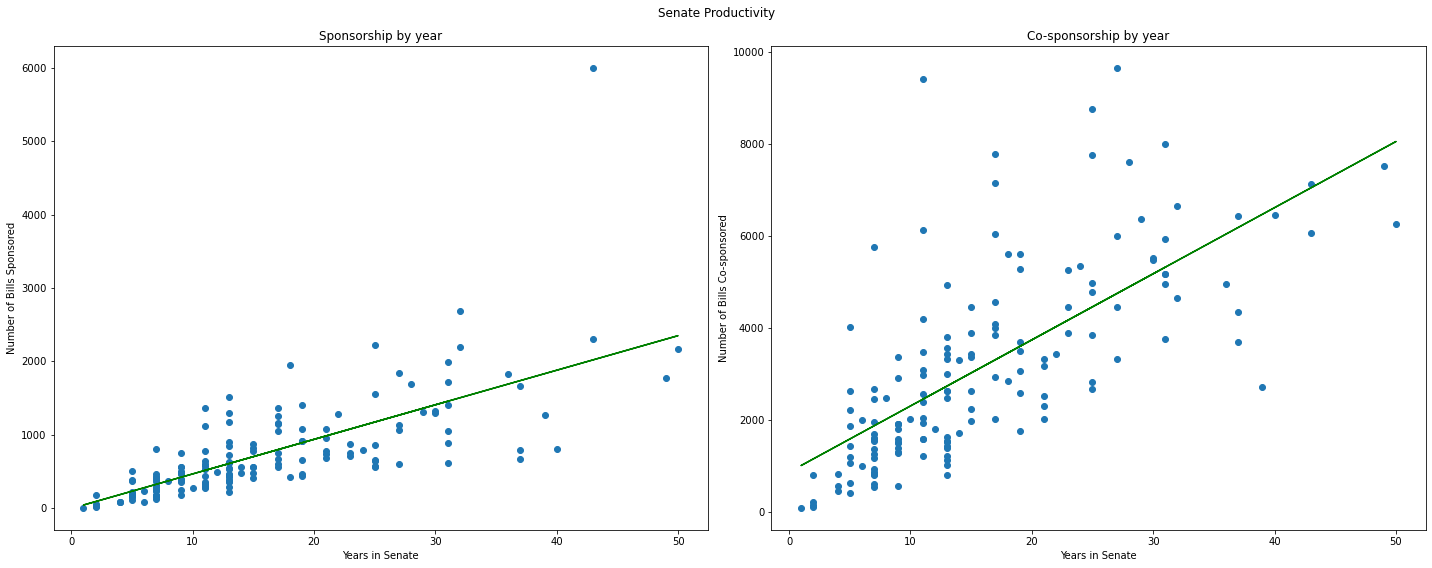

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_senate = super_senate.copy(deep=True).set_index('name')
plot_senate = plot_senate.sort_values("years_senate")
fig.suptitle("Senate Productivity")
ax1.set_title("Sponsorship by year")
ax2.set_title("Co-sponsorship by year")

ax1.scatter(super_senate['years_senate'], super_senate['sponsoredLegislation_count'])
m1, b1 = np.polyfit(super_senate['years_senate'], super_senate['sponsoredLegislation_count'], 1)
ax1.plot(super_senate['years_senate'], m1 * super_senate['years_senate'] + b1, color='green')
ax1.set_xlabel("Years in Senate")
ax1.set_ylabel("Number of Bills Sponsored")

ax2.scatter(super_senate['years_senate'], super_senate['cosponsoredLegislation_count'])
m2, b2 = np.polyfit(super_senate['years_senate'], super_senate['cosponsoredLegislation_count'], 1)
ax2.plot(super_senate['years_senate'], m2 * super_senate['years_senate'] + b2, color='green')
ax2.set_xlabel("Years in Senate")
ax2.set_ylabel("Number of Bills Co-sponsored")

fig.tight_layout()
plt.savefig(images + "productivity.png", transparent=True, facecolor='w')

**Note that the numbers of sponsored and co-sponsored bills refers to the overall number of bills of Senator, during their career and is not limited during our super-senate's time scope. Finally, for members serving in both chambers, it is not specified in which chamber did these actions occured.**

In [26]:
#Correlations

pearson_spons = scipy.stats.pearsonr(super_senate['years_senate'], super_senate['sponsoredLegislation_count'])
pearson_co = scipy.stats.pearsonr(super_senate['years_senate'], super_senate['cosponsoredLegislation_count'])

print("Pearson correlation for sponsoredLegislation_count:\n")
print("Correlation coefficient:", pearson_spons[0])
print("P-value:", pearson_spons[1])

print("\nPearson correlation for cosponsoredLegislation_count:\n")
print("Correlation coefficient:", pearson_co[0])
print("P-value:", pearson_co[1],"\n\n-----------------------------\n")

spspons = scipy.stats.spearmanr(super_senate['years_senate'], super_senate['sponsoredLegislation_count'])
spco = scipy.stats.spearmanr(super_senate['years_senate'], super_senate['cosponsoredLegislation_count'])

print("Spearman's rank correlation for sponsoredLegislation_count:\n")
print("Correlation coefficient:", spspons.correlation)
print("P-value:", spspons.pvalue)

print("\nSpearman's rank correlation for cosponsoredLegislation_count:\n")
print("Correlation coefficient:", spco.correlation)
print("P-value:", spco.pvalue)

Pearson correlation for sponsoredLegislation_count:

Correlation coefficient: 0.7067152374123926
P-value: 1.8544089038243555e-24

Pearson correlation for cosponsoredLegislation_count:

Correlation coefficient: 0.6994070858434664
P-value: 8.688342069156741e-24 

-----------------------------

Spearman's rank correlation for sponsoredLegislation_count:

Correlation coefficient: 0.8178178975289125
P-value: 4.5910905644709566e-38

Spearman's rank correlation for cosponsoredLegislation_count:

Correlation coefficient: 0.7624363816988277
P-value: 2.401363460939527e-30


- **Spearman's Correlation captures a stronger relationship between the two vectors.**
- **The amount of years in Senate is clearly correlated with the number of sponsored bills and slightly less with the number of co-sponsored bills.**
- **Very good p-values!**

In [27]:
# Define the color condition for Republican and Democrat parties
color_condition = alt.condition(
    alt.datum.party == 'Republican',  # Check if the 'party' column is 'republican'
    alt.value('red'),                 # If Republican, set color to red
    alt.value('blue')                 # If Democrat, set color to blue
)

**Republicans are represented with red color and Democrats with blue!**

Below are some interactive Altair visualizations, which may not show in the ipynb file. Please see the html files.

In [28]:
chart = alt.Chart(super_senate).mark_circle(size=100).encode(
    x=alt.X('years_senate', axis=alt.Axis(title='Years in Senate')),
    y=alt.Y('sponsoredLegislation_count', axis=alt.Axis(title='# Sponsored legislation')),
    color=color_condition,  # Apply the color condition based on 'party'
    tooltip=['name', 'birthYear', 'state']
).properties(
    width=700,
    height=400
).interactive()

chart

alt.Chart(...)

In [29]:
chart = alt.Chart(super_senate).mark_circle(size=100).encode(
    x=alt.X('years_senate', axis=alt.Axis(title='Years in Senate')),
    y=alt.Y('cosponsoredLegislation_count', axis=alt.Axis(title='# Co-sponsored legislation')),
    color=color_condition,  # Apply the color condition based on 'party'
    tooltip=['name', 'birthYear', 'state']
).properties(
    width=700,
    height=400
).interactive()

chart

alt.Chart(...)

In [30]:
chart = alt.Chart(super_senate).mark_circle(size=100).encode(
    x=alt.X('sponsoredLegislation_count', axis=alt.Axis(title='# Sponsored legislation')),
    y=alt.Y('cosponsoredLegislation_count', axis=alt.Axis(title='# Co-sponsored legislation')),
    color=color_condition,  # Apply the color condition based on 'party'
    tooltip=['name', 'birthYear', 'state']
).properties(
    width=700,
    height=400
).interactive()

chart

alt.Chart(...)

**The two classes seem somewhat linearly seperable!**

In [31]:
X = super_senate[['sponsoredLegislation_count','cosponsoredLegislation_count']].to_numpy().astype(int)
y = super_senate['party'].to_numpy()
#to make plotting clearer
y = np.where((y == 'Independent') | (y == 'Independent Democrat'), 'Democratic', y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(label_encoder.inverse_transform([0, 1]))

['Democratic' 'Republican']


Logistic Regression: Mean Accuracy = 0.6724731182795699, Standard Deviation = 0.07142116473829634


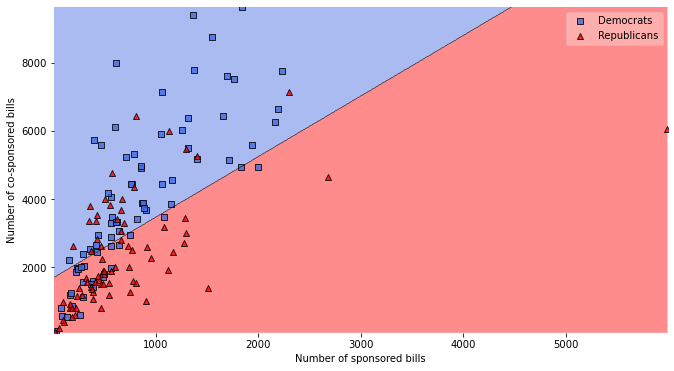

In [32]:
clf = LogisticRegression(random_state=1, solver='lbfgs')
clf.fit(X, y_encoded)

fig, ax = plt.subplots(figsize=(11, 6))

ax.set_xlabel('Number of sponsored bills')
ax.set_ylabel('Number of co-sponsored bills')
plot_decision_regions(X, y_encoded, clf=clf, legend=2, n_jobs=4, colors='royalblue,red', ax=ax)

#{'Democratic': 0, 'Republican': 1}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Democrats', 'Republicans'], framealpha=0.3, scatterpoints=1)

accuracy_scores = cross_val_score(clf, X, y_encoded, cv=5)  # 5-fold cross-validation
print(f'Logistic Regression: Mean Accuracy = {accuracy_scores.mean()}, Standard Deviation = {accuracy_scores.std()}')

Although, accuracy is not **that** great and our data consists of only a handful of congressional periods, our data does seem to suggest a pattern of Democratic Senators being more collaborative than their Republican counterparts, in terms of participating in more bills as co-sponsors.

In [33]:
super_senate.to_csv(data + "//super_senate.csv",index='bioguideId')